<a href="https://colab.research.google.com/github/siddheshdosi/Intent_Classification/blob/main/Intent_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#!pip install tf-models-official

In [7]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [1]:
#from google.colab import files

#uploaded = files.upload()

Saving intent_classification_data.csv to intent_classification_data (3).csv


In [2]:
import pandas as pd
import io

#intent_data = pd.read_csv(io.BytesIO(uploaded['intent_classification_data.csv']),encoding='latin1',names=['Sentences','Intent'])
intent_data = pd.read_csv('/content/sample_data/intent_classification_data.csv',encoding='latin1',names=['Sentences','Intent'])
intent_data = intent_data.sample(frac=1).reset_index(drop=True)
labels_map = {}
for key,value in zip(intent_data.Intent.unique().tolist(),range(0,intent_data.Intent.nunique())):
  labels_map[key]=value

In [3]:
#labels_map

# Utils

In [4]:
def train_test_split(data,test_size):
    index = round(len(data)*(1-test_size))
    train,test = data[0:index],data[index:]
    return train,test

def bert_format(data):
    bert_data = {"train": {"label": [], "sentence1": [], "sentence2": []}}
    # labels_map = {}
    # for entry in data:
    #     labels_map[entry[1]] = len(labels_map) - 1
    for entry in data:
        bert_data["train"]["label"].append(labels_map[entry[1]])
        bert_data["train"]["sentence1"].append(entry[0])
        bert_data["train"]["sentence2"].append("")
    return bert_data

def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [5]:
intent_raw_data = list(intent_data.apply(lambda x : (x[0],x[1]),axis=1))
#train,test = train_test_split(intent_raw_data,test_size=0.20)

train_bert = bert_format(intent_raw_data) 


In [16]:
#train_bert

## BERT Tokenizer

In [8]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)
 
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [9]:
# Tokenize a sentence example
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [10]:
train_data = bert_encode(train_bert['train'], tokenizer)
train_labels = train_bert['train']['label']

In [11]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [12]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=21)

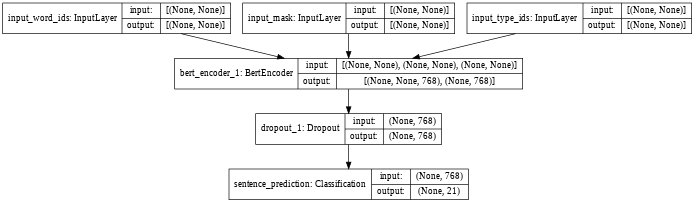

In [13]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [14]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [15]:
# Set up epochs and steps
epochs = 5
batch_size = 8

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    5e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
#type(optimizer)
#print(num_train_steps)
#print(train_labels)

In [16]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)
bert_classifier.fit(
      x=train_data, y=np.array(train_labels),
      batch_size=batch_size,
      epochs=epochs)

Epoch 1/5
140/140 [==============================] - 443s 3s/step - loss: 2.8216 - accuracy: 0.1827
Epoch 2/5
140/140 [==============================] - 426s 3s/step - loss: 1.0482 - accuracy: 0.7827
Epoch 3/5
140/140 [==============================] - 427s 3s/step - loss: 0.2637 - accuracy: 0.9655
Epoch 4/5
140/140 [==============================] - 424s 3s/step - loss: 0.1294 - accuracy: 0.9811
Epoch 5/5
140/140 [==============================] - 422s 3s/step - loss: 0.0624 - accuracy: 0.9959


In [20]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'money debited from account but payment did not updated in the system.',
            'how to talk to support team',
            'I apply online',
            "not able to login with my username."],
        'sentence2':[
            '',
            '',
            '',
            '']
    },
    tokenizer=tokenizer)

In [21]:
results = bert_classifier(my_examples, training=False)

results = tf.argmax(results, axis=-1).numpy()
labels = ["undefined"] * 21
for key, value in labels_map.items():
  labels[value] = key
for result in results:
  print(labels[result])

faq.bad_service
contact.contact
faq.apply_register
faq.bad_service


In [19]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())